# Token-based Knowledge Distillation


In the previous notebook, we looked at the challenges of training ViTs on small datasets. In this deliverable, we would explicitly carry out knowledge distillation in context of vision transformers to reduce the large number of training examples that they require to make useful inferences. In particular, we would be carrying out token-based distillation as introduced by the [DeIT paper](https://arxiv.org/abs/2012.12877). Since the resources and time required for training these models on even moderate size datasets like Tiny ImageNet is too much, we would be carrying out our training on **tf_flowers** which consists of 5 classes and a total of 3700 images. The problem is much more tractable for these datasets, and it allows us to see the main takeaways from the paper clearly.

For this notebook, I will be switching from pytorch to keras library. The reason being that we have the availability of pretrained CNNs which can be finetune to our task very easily on Keras. We would be using a model from the BiT family of ResNets trained in the paper [Big Transfer (BiT): General Visual Representation Learning](https://arxiv.org/abs/1912.11370). This model comes finetuned with its finetuning on tf_flowers being carried out in the following notebook: [BiT teacher](https://github.com/sayakpaul/deit-tf/blob/main/notebooks/bit-teacher.ipynb)

**The model contains 212 Million parameters which is about 40x more than the student.**


## Imports

In [ ]:
#!pip install tensorflow_hub
#!pip install keras

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
from typing import List

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


# Performing Splits & Data Loaders

We create the class Dataset Processor to handle datasets preprocessing and preparation for training and validation. The class encapsulates functions for resizing images, performing random crops and flips during training, and converting labels to one-hot encoding.

In [ ]:
RESOLUTION = 224
NUM_CLASSES = 5
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

class DatasetProcessor:
    def __init__(self, resolution=RESOLUTION, num_classes=NUM_CLASSES, batch_size=BATCH_SIZE):
        self.resolution = resolution
        self.num_classes = num_classes
        self.batch_size = batch_size

    def preprocess_dataset(self, is_training=True):
        def fn(image, label):
            if is_training:
                image = tf.image.resize(image, (self.resolution + 20, self.resolution + 20))
                image = tf.image.random_crop(image, (self.resolution, self.resolution, 3))
                image = tf.image.random_flip_left_right(image)
            else:
                image = tf.image.resize(image, (self.resolution, self.resolution))
            label = tf.one_hot(label, depth=self.num_classes)
            return image, label

        return fn

    def prepare_dataset(self, dataset, is_training=True):
        if is_training:
            dataset = dataset.shuffle(self.batch_size * 10)
        dataset = dataset.map(self.preprocess_dataset(is_training), num_parallel_calls=AUTO)
        return dataset.batch(self.batch_size).prefetch(AUTO)

# Usage
dataset_processor = DatasetProcessor()

train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = dataset_processor.prepare_dataset(train_dataset, is_training=True)
val_dataset = dataset_processor.prepare_dataset(val_dataset, is_training=False)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


# Model Hyper Parameters

In [ ]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

# Implementing Stochastic Depth

Touvron et al implements Stochastic depth which **"faciliates the convergence of transformers"**. The paper talks about how they were first implemented by Wightman in context of vision transformers.

Conceptually, Stochastic depths are very similar to dropouts and they act as regularizers. It aims to shrink the depth of a network during training, while keeping it unchanged during testing. This is acheived by randomly droping layers during the training process and bypassing their transformations through skip connections.



In [ ]:
class RandomizedDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

There is very minor difference between the Vanilla Vits and DeIT. Hence, the MLP and transformer block remains the same and we can copy them from previous implementations.

In [ ]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""

    # defining the number of patches depending upon wheather we are
    # distlling or not.

    if "distilled" in MODEL_TYPE:
      num_patches = NUM_PATCHES + 2
    else:
      num_patches = NUM_PATCHES + 1

    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))
    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        RandomizedDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = RandomizedDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [ ]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

# DeIT-token

The main distinction between the ViT model that we created in the first delivarable (besides the shifted-patches and attention-masking to gain better accuracy on smaller datasets) is that of a distillation token. Consider the figure below:

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-12-24_at_1.16.17_PM_4ybxEGe.png" width="400" height="400">


Notice  the distinction between ViT and DeIT (besides the loss function), is that we now send a distillation token alongside patch tokens and class tokens. Now, *the logits corresponding to the class tokens are compared to the true labels, and the logits corresponding to the distillation token are compared to the teacher's predictions.* (**Explore Architectural Changes here**)



In [ ]:
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training


        # WE now define a distillation token that creates a tensor that
        # can be trained and updated during the optimization process. Unlike
        #regular tensors that are recalculated each time they are used,
        #tf.variable will ensure dist_token maintain its state across the
        #execution of the program. This means that self.dist_token will
        #retain its value across different batches of data and epochs of
        #training
        init_value = tf.zeros((1, 1, PROJECTION_DIM))

        self.dist_token = tf.Variable(init_value, name="dist_token")
        #print(self.dist_token.shape)

        # same as before
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

       # we now create one more head. The distillation head is used to learn
       # from a teacher logits rather than from output labels. That is,
       # the teacher logits are used to calculate the loss function.

        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # normal patches
        projected_patches = self.projection(inputs)

        # distinct tokens .

        # replicating these tokens n times along the batch dimensio
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))

        # ensuring that the datatype of distinct token and projected patches
        # is same
        cls_token = tf.cast(cls_token, projected_patches.dtype)

        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # positional embeddings.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)


        for transformer_module in self.transformer_blocks:
            encoded_patches = transformer_module(encoded_patches)

        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

In [ ]:


deit_tiny_distilled = ViTDistilled()

dummy_inputs = tf.ones((2, 224, 224, 3)) # we send two images of 224 x 224 pixels


outputs = deit_tiny_distilled(dummy_inputs, training=False)
print(outputs.shape)

the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
(1, 1, 192)
(2, 5)


# In Detail Computational Flow & Understanding of Distillation token:

Each image in our dataset has the dimensionality (224 x 224 x 3). Since our patches are 16 x 16 x 3, in total we obtain 196 patches (N = $HW/P^2$) with each patch being a dimension of 768 after being flattened. We map each of the patch into the embedding space of dimension 192.  With the addition of class token and distillation token, the total number of patches goes up from 196 to 198. Standard procecure of adding positional embedding is followed and the patches along with the **distillation token** is sent through the transformer encoder. The output through the encoder is B x 198 x 192.

Note that intially, the distillation token has no correlation with teacher model. Instead, it learns to mimic the teacher output using backpropogation. The distillation loss is computed **ONLY** with respect to the distillation token. Once we are out of the transformer encode, the 196 patches go into the transformer MLP where they produce the **student logits**. On the other hand, the distillation token go into the distillation MLP where it produces the **distillation logits**. See the image below.


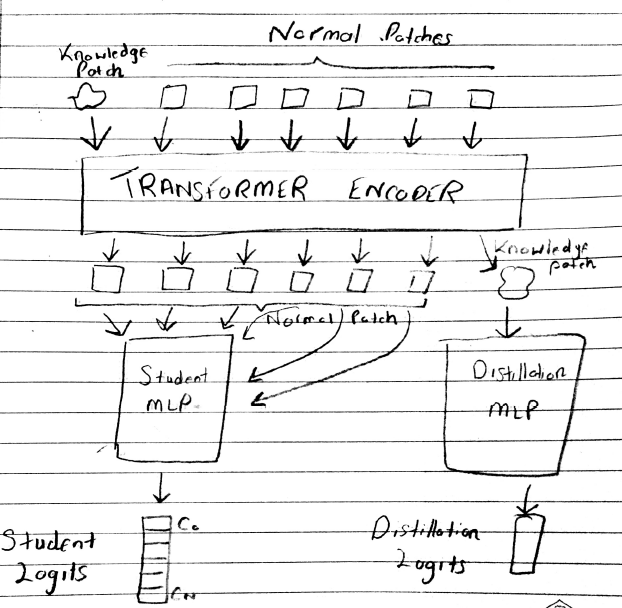

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Datasets/knowledge_distill.png'))

Notice that the main place where the token interacts with other patches and guide their learning is in the Transformer Encoder. The best analogy that I have come up with to understand and gain some insight about this is think in context of NLP. Suppose I am sending the words, *I*, *have*, *a*, *pen*. Now, I send anothe word *Pine* which is my teacher token. Notice how it will now interact with all other tokens (I, have, a, pen) as a attention score against all tokens against it will be computed.

**Speculative thoughts** :
How might this allow other patches to *converge faster to true values?* Notice you can think of this interaction as some form of *probability subtraction*. Instead of having the entire $P_{i} = 1$ accessible to each token, it now has been reduced to $1 - P_{t}$ where $P_{t}$ is the attention score associated with the said token with the distilled token. Maybe that is helping?

The student MLP produces a logits $Z_s$ which in this case has a dimensionality of 5. Similarly, the distillation MLP logits is $Z_s$ which also has a dimensionality of 5. **Note that although these logits are denoted by the same symbol, they are different from each other (something that is not obvious from the loss function).** . We would use the actual label $y $ of the image against the student MLP calculate one loss. For the second, we would use the label $y_t$ of the teacher against the distllation logits (for about this below).  

# Choice of Loss Function in ViTs

In soft distillation, our objective is to minimize the Kullback-Leibler (KL) divergence between the softmax outputs of the teacher model and the student model. Given $Z_t$ as the logits of the teacher model and $Z_s$ as the logits of the student model, knowledge distillation by Hinton et al introduced the temperature parameter $\tau$ for distillation and $\lambda$ as the coefficient that balances the KL divergence loss KL  and the cross-entropy loss $L_{CE}$ on the true labels `y`. If we denote the softmax function by $\sigma$, then the normal distillation loss is the following:
$$
L_{global} = (1 - \lambda ) L_{CE}(\sigma(Z_s), y) + \lambda * \tau^2 * KL(\sigma(Z_s/τ), \sigma(Z_t/τ))
$$


The paper propose an even simpler version of distillation (which givess better results in their experiments). The hard decision $y_t$ is the actual decision of the teacher rather than logits. They take the distillation loss against the actual outcome $y_t$ rather than the logits such that the function above becomes:  

$$
L_{global}^{hardDistill} = \frac{1}{2} L_{CE}(\sigma(Z_s), y) + \frac{1}{2}L_{CE}(\sigma(Z_s), y_{t})
$$





In [ ]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data
        print("shape of x is , " , x.shape)
        print("shape of y is , ", y.shape)


        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)
        print("teacher hard prediction is ", teacher_predictions)


        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)
            print("distillation prediction is ", dist_predictions.shape)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

# Teacher Model

We have already talked about the teacher model and its parameters in detail above.

In [ ]:
model_path = "/content/drive/MyDrive/Datasets/bit_teacher_flowers"
bit_teacher_flowers = keras.models.load_model(model_path)


# Training

In [ ]:
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Check if GPU is available
if any(device.device_type == 'GPU' for device in physical_devices):
    print("Training on GPU.")
else:
    print("Training on CPU.")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Training on CPU.


In [ ]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
_ = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
the dimension of the output is ,  (None, 198, 192)
(1, 1, 192)
Epoch 1/20
shape of x is ,  (None, 224, 224, 3)
shape of y is ,  (None, 5)
teacher hard prediction is  Tensor("ArgMax:0", shape=(None,), dtype=int64)
distillation prediction is  (None, 5)
shape of x is ,  (None, 224, 224, 3)
shape of y is ,  (None, 5)
teacher hard prediction is  Tensor("ArgMax:0", shape=(None,), dtype=int64)
distillation prediction is  (None, 5)
